In [1]:
# Run this cell to upload your kaggle.json
from google.colab import files
files.upload() # Choose the kaggle.json file you downloaded

# Make directory and move kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [4]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 87% 249M/285M [00:00<00:00, 565MB/s]
100% 285M/285M [00:03<00:00, 94.5MB/s]


In [5]:
!unzip -q challenges-in-representation-learning-facial-expression-recognition-challenge.zip -d fer2013_data

In [14]:
!git clone https://github.com/enelene/Facial-Expression-Recognition-Challenge.git

Cloning into 'Facial-Expression-Recognition-Challenge'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (4/4), done.


In [16]:
mv

/content/Facial-Expression-Recognition-Challenge


In [17]:
!pip install wandb -q

In [18]:
import wandb
wandb.login()


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: egabe21 (egabe21-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt


In [23]:
!tar -xzvf ../fer2013_data/fer2013.tar.gz -C ../fer2013_data/

fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/


In [24]:
cat ../fer2013_data/fer2013/README

If you use this dataset in your research work, please cite

"Challenges in Representation Learning: A report on three machine learning
contests." I Goodfellow, D Erhan, PL Carrier, A Courville, M Mirza, B
Hamner, W Cukierski, Y Tang, DH Lee, Y Zhou, C Ramaiah, F Feng, R Li,
X Wang, D Athanasakis, J Shawe-Taylor, M Milakov, J Park, R Ionescu,
M Popescu, C Grozea, J Bergstra, J Xie, L Romaszko, B Xu, Z Chuang, and
Y. Bengio. arXiv 2013.

See fer2013.bib for a bibtex entry.


In [26]:
import pandas as pd

# Try loading train.csv first
try:
    train_df = pd.read_csv('fer2013_data/train.csv')
    print("train.csv head:")
    print(train_df.head())
    print("\ntrain.csv columns:", train_df.columns)
    print("\ntrain.csv info:")
    train_df.info()
except FileNotFoundError:
    print("train.csv not found directly. Was fer2013.tar.gz extracted if it contained it?")

# Similarly for test.csv
try:
    test_df = pd.read_csv('fer2013_data/test.csv')
    print("\ntest.csv head:")
    print(test_df.head())
except FileNotFoundError:
    print("test.csv not found directly.")


# And icml_face_data.csv
try:
    icml_df = pd.read_csv('fer2013_data/icml_face_data.csv')
    print("\nicml_face_data.csv head:")
    print(icml_df.head())
    print("\nicml_face_data.csv columns:", icml_df.columns)
    print("\nicml_face_data.csv info:")
    icml_df.info()
except FileNotFoundError:
    print("icml_face_data.csv not found directly.")

train.csv head:
   emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...

train.csv columns: Index(['emotion', 'pixels'], dtype='object')

train.csv info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
dtypes: int64(1), object(1)
memory usage: 448.7+ KB

test.csv head:
                                              pixels
0  254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1  156 184 198 202 204 207 210 212 213 214 215 21...
2  69 118 61 60 96 121 103 87 103 88 70 90 115 

In [27]:
try:
    fer2013_df = pd.read_csv('fer2013_data/fer2013/fer2013.csv')
    print("\nfer2013.csv head:")
    print(fer2013_df.head())
except FileNotFoundError:
    print("test.csv not found directly.")


fer2013.csv head:
   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


In [30]:
data_path = 'fer2013_data/icml_face_data.csv'
df = pd.read_csv(data_path)

df.columns = df.columns.str.strip()
print("Cleaned column names:", df.columns)

print(df.head())
print("\nDataset shape:", df.shape)
print("\nEmotion distribution:\n", df['emotion'].value_counts())
print("\nUsage distribution:\n", df['Usage'].value_counts())

# Emotion labels (as defined before)
emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
num_classes = len(emotion_labels)

# --- 2. Split DataFrames based on 'Usage' column ---
train_df = df[df['Usage'] == 'Training']
val_df = df[df['Usage'] == 'PublicTest']
test_df = df[df['Usage'] == 'PrivateTest']

print(f"\nTraining samples: {len(train_df)}")
print(f"Validation samples (PublicTest): {len(val_df)}")
print(f"Test samples (PrivateTest): {len(test_df)}")


Cleaned column names: Index(['emotion', 'Usage', 'pixels'], dtype='object')
   emotion     Usage                                             pixels
0        0  Training  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  Training  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  Training  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  Training  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  Training  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...

Dataset shape: (35887, 3)

Emotion distribution:
 emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

Usage distribution:
 Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

Training samples: 28709
Validation samples (PublicTest): 3589
Test samples (PrivateTest): 3589


In [31]:
class FER2013Dataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.pixel_strings = self.df['pixels'].values
        self.emotions = self.df['emotion'].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Convert pixel string to numpy array and then to PIL Image
        pixel_data = np.fromstring(self.pixel_strings[idx], dtype=int, sep=' ').reshape(48, 48).astype('uint8')
        image = Image.fromarray(pixel_data) # Create PIL image from grayscale numpy array
        emotion = torch.tensor(self.emotions[idx], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, emotion

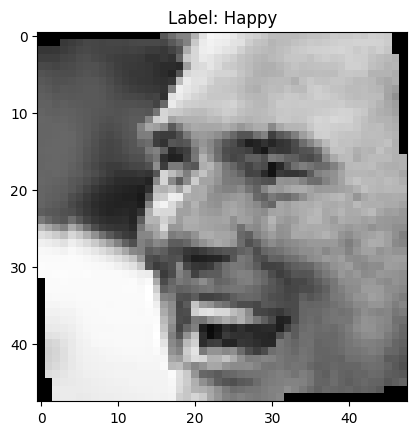

In [40]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

if 'train_df' in locals():
    train_dataset = FER2013Dataset(train_df, transform=train_transform)
    val_dataset = FER2013Dataset(val_df, transform=val_test_transform) # Use PublicTest for validation
    test_dataset = FER2013Dataset(test_df, transform=val_test_transform)  # Use PrivateTest for final testing

    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    # Visualize a sample
    def imshow(tensor_img, title=None):
        img = tensor_img.clone().squeeze(0)
        img = img * 0.5 + 0.5 # Unnormalize
        plt.imshow(img.numpy(), cmap='gray')
        if title is not None:
            plt.title(title)
        plt.show()

    try:
        images, labels = next(iter(train_loader))
        idx_to_show = 0
        imshow(images[idx_to_show], title=f"Label: {emotion_labels[labels[idx_to_show].item()]}")
    except Exception as e:
        print(f"Could not display image: {e}.")
else:
    print("train_df not defined. Skipping DataLoader and visualization.")

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
import pandas as pd

In [43]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes_param):
        super(SimpleCNN, self).__init__()
        # Input is 1x48x48 (grayscale)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        # (16, 48, 48)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # (16, 24, 24)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # (32, 24, 24)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # (32, 12, 12)

        # Flatten the output for the fully connected layer
        # 32 channels * 12 * 12 image size = 32 * 144 = 4608
        self.fc1 = nn.Linear(32 * 12 * 12, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5) # Basic regularization
        self.fc2 = nn.Linear(128, num_classes_param)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 32 * 12 * 12) # Flatten
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [44]:
if 'num_classes' not in globals():
    print("Error: num_classes is not defined.")
    exit()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Ensure num_classes is defined before this line
model = SimpleCNN(num_classes_param=num_classes).to(device)
print(model)

criterion = nn.CrossEntropyLoss()
learning_rate_initial = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate_initial)


Using device: cuda
SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=128, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
)


In [45]:
config_wandb = {
    "learning_rate": learning_rate_initial,
    "architecture": "SimpleCNN_Baseline",
    "dataset": "FER2013_from_icml_face_data",
    "epochs": 15, # Start with a moderate number for the baseline
    "batch_size": batch_size,
    "optimizer": "Adam",
    "criterion": "CrossEntropyLoss",
    "dropout_fc": 0.5,
    "notes": "Baseline model with 2 conv layers and 1 dropout layer in FC part."
}

# Start a new wandb run to track this script
run = wandb.init(
    project="facial-expression-recognition-challenge",
    config=config_wandb,
    name=f"run-{config_wandb['architecture']}-{pd.Timestamp.now().strftime('%Y%m%d-%H%M%S')}" # Unique run name
)


In [46]:
def train_model_func(model_to_train, t_loader, v_loader, loss_criterion, opt, num_epochs_total, dev, current_wandb_run, run_name_prefix="train"):

    best_val_accuracy = 0.0
    best_model_path = f"{run_name_prefix}_best_model.pth"

    current_wandb_run.watch(model_to_train, loss_criterion, log="gradients", log_freq=100) # log_freq is per batch

    for epoch in range(num_epochs_total):
        model_to_train.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (images, labels) in enumerate(t_loader):
            images = images.to(dev)
            labels = labels.to(dev)

            outputs = model_to_train(images)
            loss = loss_criterion(outputs, labels)

            opt.zero_grad()
            loss.backward()
            opt.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            if (i + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs_total}], Step [{i+1}/{len(t_loader)}], Batch Loss: {loss.item():.4f}')

        epoch_train_loss = running_loss / len(t_loader.dataset)
        epoch_train_acc = correct_train / total_train

        # Validation phase
        model_to_train.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in v_loader:
                images = images.to(dev)
                labels = labels.to(dev)
                outputs = model_to_train(images)
                loss = loss_criterion(outputs, labels)

                running_val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / len(v_loader.dataset)
        epoch_val_acc = correct_val / total_val

        print(f'Epoch [{epoch+1}/{num_epochs_total}]:')
        print(f'  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}')
        print(f'  Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')

        # Log metrics to Wandb
        current_wandb_run.log({
            "epoch": epoch + 1,
            "train_loss": epoch_train_loss,
            "train_accuracy": epoch_train_acc,
            "val_loss": epoch_val_loss,
            "val_accuracy": epoch_val_acc,
            "learning_rate_current": opt.param_groups[0]['lr'] # Log current LR
        })

        if epoch_val_acc > best_val_accuracy:
            best_val_accuracy = epoch_val_acc
            torch.save(model_to_train.state_dict(), best_model_path)
            wandb.save(best_model_path) # This saves the file to Wandb's cloud storage for the run
            print(f"New best model saved with accuracy: {best_val_accuracy:.4f} at epoch {epoch+1}")

    print('Finished Training')
    print(f"Best validation accuracy during training: {best_val_accuracy:.4f}")
    #loading the best model state for any final evaluations after the loop
    model_to_train.load_state_dict(torch.load(best_model_path))
    return best_model_path



In [47]:
# run the Training for the Baseline Model ---
# Ensure train_loader and val_loader are defined and not empty
if 'train_loader' in globals() and len(train_loader) > 0 and 'val_loader' in globals() and len(val_loader) > 0:
    print(f"Starting training for the baseline model: {config_wandb['architecture']}")
    best_model_file_baseline = train_model_func(model, train_loader, val_loader, criterion, optimizer,
                                      num_epochs_total=config_wandb["epochs"], dev=device,
                                      current_wandb_run=run,
                                      run_name_prefix=config_wandb["architecture"])
    print(f"Best model from baseline training saved to: {best_model_file_baseline}")

    trained_model_artifact = wandb.Artifact(
        name = f"{config_wandb['architecture']}_final_model",
        type="model",
        description=f"Final trained model state for {config_wandb['architecture']}",
        metadata=config_wandb # Add all hyperparameters
    )
    trained_model_artifact.add_file(best_model_file_baseline)
    run.log_artifact(trained_model_artifact)
    print(f"Logged {best_model_file_baseline} as a Wandb artifact.")

else:
    print("DataLoaders (train_loader or val_loader) are not properly initialized or are empty. Skipping training.")


# --- 6. Finish the Wandb Run ---
if 'run' in globals() and run is not None:
    run.finish()
    print("Wandb run finished.")

Starting training for the baseline model: SimpleCNN_Baseline
Epoch [1/15], Step [100/449], Batch Loss: 1.7912
Epoch [1/15], Step [200/449], Batch Loss: 1.7170
Epoch [1/15], Step [300/449], Batch Loss: 1.7050
Epoch [1/15], Step [400/449], Batch Loss: 1.6390
Epoch [1/15]:
  Train Loss: 1.6875, Train Acc: 0.3251
  Val Loss: 1.5243, Val Acc: 0.4171
New best model saved with accuracy: 0.4171 at epoch 1
Epoch [2/15], Step [100/449], Batch Loss: 1.5609
Epoch [2/15], Step [200/449], Batch Loss: 1.4988
Epoch [2/15], Step [300/449], Batch Loss: 1.5701
Epoch [2/15], Step [400/449], Batch Loss: 1.6042
Epoch [2/15]:
  Train Loss: 1.5321, Train Acc: 0.4081
  Val Loss: 1.4390, Val Acc: 0.4517
New best model saved with accuracy: 0.4517 at epoch 2
Epoch [3/15], Step [100/449], Batch Loss: 1.7228
Epoch [3/15], Step [200/449], Batch Loss: 1.3938
Epoch [3/15], Step [300/449], Batch Loss: 1.4110
Epoch [3/15], Step [400/449], Batch Loss: 1.5964
Epoch [3/15]:
  Train Loss: 1.4583, Train Acc: 0.4390
  Val Los

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
learning_rate_current,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▅▅▆▆▇▇▇▇▇████
train_loss,█▆▄▄▃▃▃▂▂▂▂▂▁▁▁
val_accuracy,▁▃▄▅▆▆▇▇▇▇▇████
val_loss,█▆▅▄▃▃▂▂▂▁▂▁▁▁▁
epoch,15
learning_rate_current,0.001
train_accuracy,0.5314
train_loss,1.22942
val_accuracy,0.54556


Wandb run finished.
